In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import re
import itertools
import time
import joblib
import random

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 15
pd.options.display.max_colwidth = -1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import auc, roc_curve, make_scorer
from sklearn import svm, ensemble, datasets

In [3]:
import parsl
parsl.clear()

from polyfuse.configs.local import config
parsl.load(config)

#parsl.load()

from polyfuse import apps, transformations

In [4]:
out_dir = '/cephfs/users/annawoodard/polyfuse/data/sim_50/processed'
training_fraction = 0.85

In [5]:
truth = apps.concatenate_true_fusions('/cephfs/users/annawoodard/fusion-simulation/data/processed/*', out_dir)

In [6]:
truth = pd.read_hdf(truth.result(), 'data')

In [7]:
callers = ['starseqr', 'starfusion', 'arriba', 'fusioncatcher', 'pizzly']

In [61]:
parsed_caller_data = apps.parse_caller_data(out_dir, callers)

In [62]:
caller_data_path = apps.concatenate_caller_data(out_dir, inputs=parsed_caller_data)
caller_data = pd.read_hdf(caller_data_path.result(), 'data')

In [63]:
samples = sorted(caller_data['sample'].unique())
#random.shuffle(samples)
training_samples = samples[:int(len(samples) * training_fraction)]
testing_samples = samples[int(len(samples) * training_fraction):]

In [64]:
start = time.time()
x_train, y_train = apps.assemble_data(training_samples, callers, out_dir)
print('assembled data in {:.1f}s'.format((time.time() - start)))

assembled data in 65.2s


In [71]:
start = time.time()
os.makedirs(os.path.join(out_dir, 'models'), exist_ok=True)

base_columns = []
for c in callers:
    base_columns += [c + '_spanning_reads', c + '_junction_reads']
classifiers = []
for features in [
            base_columns,
            base_columns + [
                'arriba_confidence_high', 'arriba_confidence_low', 'arriba_confidence_medium',
                'arriba_reading_frame_in-frame', 'arriba_reading_frame_out-of-frame'
            ],
        ]:
    #label = 'LSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.LinearSVC(probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]


    #label = 'DefaultSVC{}features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(probability=True)
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]

    #label = 'SVC{}Features'.format(len(features))
    #trans = 'flatten'
    #classifier = svm.SVC(C=10, gamma='auto', probability=True)
    #print(label, classifier.get_params())
    #classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    #joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    #classifiers += [(features, label, trans)]
    
    label = 'RFC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.RandomForestClassifier()
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]

    
    label = 'GBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier(learning_rate=0.05, n_estimators=750, subsample=0.9)
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]

    label = 'DefaultGBC{}F'.format(len(features))
    trans = 'noop'
    classifier = ensemble.GradientBoostingClassifier()
    classifier.fit(getattr(transformations, trans)(x_train[features]), y_train)
    joblib.dump(classifier, os.path.join(out_dir, 'models', label + '.joblib'))
    classifiers += [(features, label, trans)]

print('fit models in {:.1f}s'.format((time.time() - start)))


fit models in 173.5s


In [72]:
x_train.shape, sum(y_train)

((63025, 18), 34000)

In [73]:
start = time.time()
model_data = pd.read_hdf(
    apps.predict(testing_samples, out_dir, classifiers, callers), 'data'
)
print('assembled predictions in {:.1f}s'.format((time.time() - start)))

assembled predictions in 71.3s


In [74]:
summary = apps.make_summary(out_dir, testing_samples)

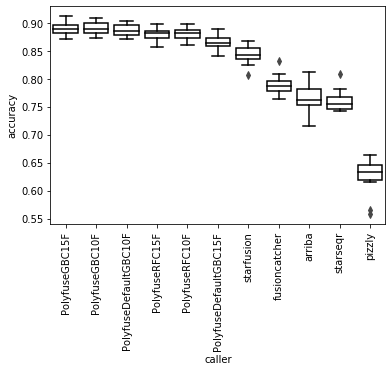

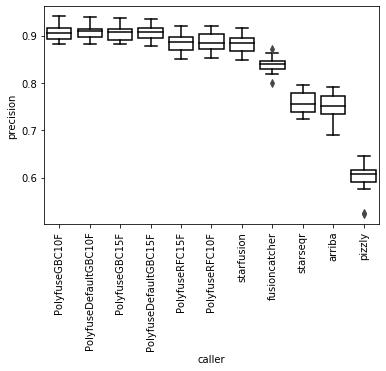

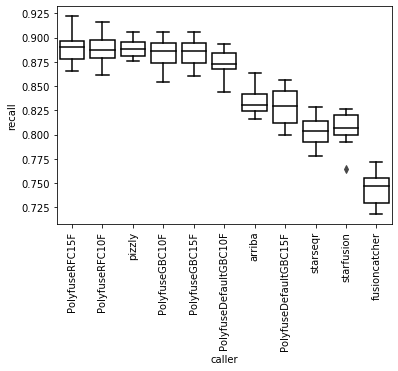

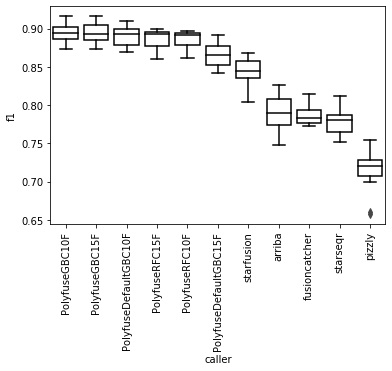

In [75]:
os.makedirs('plots', exist_ok=True)
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.figure()
    ax = sns.boxplot(x="caller", y=metric, data=summary.sort_values(by=metric, ascending=False))
    labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    _ = plt.setp(ax.artists, edgecolor = 'k', facecolor='w')
    _ = plt.setp(ax.lines, color='k')
    plt.savefig('plots/{}.pdf'.format(metric))

In [76]:
summary.groupby('caller').mean().sort_values(by='accuracy', ascending=False)

,tp,fp,fn,tn,recall,precision,accuracy,f1,mcc
caller,,,,,,,,,
PolyfuseGBC10F,441.750000,46.000000,58.250000,407.083333,0.883500,0.905905,0.890719,0.894458,0.781034
PolyfuseGBC15F,442.083333,46.583333,57.916667,406.500000,0.884167,0.904866,0.890384,0.894315,0.780294
PolyfuseDefaultGBC10F,436.583333,44.250000,63.416667,408.833333,0.873167,0.908159,0.887098,0.890220,0.774264
PolyfuseRFC10F,444.000000,58.416667,56.000000,394.666667,0.888000,0.884125,0.879986,0.885905,0.758883
PolyfuseRFC15F,444.750000,59.250000,55.250000,393.833333,0.889500,0.882799,0.879954,0.886001,0.758774
PolyfuseDefaultGBC15F,414.833333,43.333333,85.166667,409.750000,0.829667,0.905470,0.865212,0.865853,0.733177
starfusion,403.083333,53.166667,96.916667,399.916667,0.806167,0.883525,0.842497,0.843047,0.687987
fusioncatcher,371.500000,71.750000,128.500000,381.333333,0.743000,0.838430,0.789370,0.787688,0.583872
arriba,417.500000,141.500000,82.500000,311.583333,0.835000,0.747741,0.764998,0.788789,0.528833


In [ ]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    auroc = metrics.roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label='{} (AUROC = {:0.2f})'.format(caller, auroc))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(frameon=False)

PolyfuseRFC10F


PolyfuseRFC4F
PolyfuseGBC4F
PolyfuseDefaultGBC4F
PolyfuseRFC7F
PolyfuseGBC7F
PolyfuseDefaultGBC7F


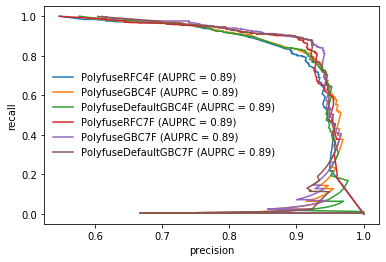

In [27]:
sample = model_data['sample'].unique()[0]
plt.figure()
for caller in model_data.caller.unique():
    print(caller)
    try:
        y_true, y_pred, y_prob = apps.score_model(out_dir, sample, caller).result()
    except:
        continue

    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_prob)
    auprc = auc(recall, precision)
    plt.plot(precision, recall, label='{} (AUPRC = {:0.2f})'.format(caller, auroc))

plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(frameon=False)
# looks funky, but see: https://stats.stackexchange.com/questions/183504/are-precision-and-recall-supposed-to-be-monotonic-to-classification-threshold

In [34]:
caller_data

,spanning_reads,junction_reads,sample,caller,gene1,gene2,confidence,fusion,sum_J_S
0,1802,25,LIB-03335WT,fusioncatcher,UBE2QL1,GREB1,NaN,UBE2QL1--GREB1,1827
1,1785,25,LIB-03335WT,fusioncatcher,SRCAP,C12ORF43,NaN,SRCAP--C12ORF43,1810
2,1723,25,LIB-03335WT,fusioncatcher,ABAT,KNSTRN,NaN,ABAT--KNSTRN,1748
3,1709,25,LIB-03335WT,fusioncatcher,HEPHL1,TRMT10C,NaN,HEPHL1--TRMT10C,1734
4,1704,25,LIB-03335WT,fusioncatcher,HFM1,KIAA1257,NaN,HFM1--KIAA1257,1729
...,...,...,...,...,...,...,...,...,...
218633,42,144,LIB-006806wt,pizzly,ROBO2,LYVE1,NaN,ROBO2--LYVE1,186
218634,4,15,LIB-006806wt,pizzly,TMOD2,TP73,NaN,TMOD2--TP73,19
218635,112,415,LIB-006806wt,pizzly,B3GAT2,PDSS2,NaN,B3GAT2--PDSS2,527
218636,2,14,LIB-006806wt,pizzly,AP5S1,CCL15,NaN,AP5S1--CCL15,16


In [35]:
x_train

,starseqr,starfusion,arriba,fusioncatcher,pizzly,arriba_confidence_high,arriba_confidence_medium,arriba_confidence_low,arriba_confidence_nan
0,0,5,4,0,4,0,0,1,0
1,1394,1392,563,875,954,1,0,0,0
2,1886,1899,653,1152,1296,1,0,0,0
3,101,116,94,93,75,1,0,0,0
4,26,25,25,24,24,1,0,0,0
...,...,...,...,...,...,...,...,...,...
993,0,0,0,0,6,0,0,0,1
994,0,0,0,0,21,0,0,0,1
995,121,289,257,206,229,1,0,0,0
996,6,8,6,8,6,1,0,0,0


In [37]:
caller_data[caller_data.confidence == 'high']

,spanning_reads,junction_reads,sample,caller,gene1,gene2,confidence,fusion,sum_J_S
1446,300,595,LIB-03335WT,arriba,SRCAP,C12orf43,high,SRCAP--C12orf43,895
1447,300,584,LIB-03335WT,arriba,LACRT,ZNF557,high,LACRT--ZNF557,884
1448,300,571,LIB-03335WT,arriba,PRDM13,PGF,high,PRDM13--PGF,871
1449,299,570,LIB-03335WT,arriba,HEPHL1,TRMT10C,high,HEPHL1--TRMT10C,869
1450,300,565,LIB-03335WT,arriba,CDC37L1,ATE1,high,CDC37L1--ATE1,865
...,...,...,...,...,...,...,...,...,...
217762,1,2,LIB-006806wt,arriba,SLC16A1,CTRB1,high,SLC16A1--CTRB1,3
217763,2,1,LIB-006806wt,arriba,C1orf52,FSHB,high,C1orf52--FSHB,3
217764,1,2,LIB-006806wt,arriba,LILRB3,SIN3B,high,LILRB3--SIN3B,3
217765,1,1,LIB-006806wt,arriba,BX664727.3,POP1,high,BX664727.3--POP1,2


In [52]:
caller_data.loc[caller_data['sample'] == 'LIB-03335', ['gene1', 'gene2']].values[0].tolist()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [39]:
data = pd.read_pickle('/cephfs/users/annawoodard/polyfuse/data/sim_50/processed/LIB-04674wt/arriba/fusions.pkl')

In [40]:
data

,gene1,gene2,strand1(gene/fusion),strand2(gene/fusion),breakpoint1,breakpoint2,site1,site2,type,direction1,direction2,split_reads1,split_reads2,discordant_mates,coverage1,coverage2,confidence,closest_genomic_breakpoint1,closest_genomic_breakpoint2,filters,fusion_transcript,reading_frame,peptide_sequence,read_identifiers,fusion,junction_reads,spanning_reads,caller,sample
0,SRCAP,FAM228A,+/+,+/+,16:30720331,2:24179111,splice-site,splice-site,translocation,downstream,upstream,301,294,300,1624,2064,high,.,.,"duplicates(37),low_entropy(34),mismatches(2)",CGCTGCAGGCTCTCCAAGCGTCAACGCTGTCTCTATGATGACTTCATGGC...ACACTAGCCACAGGCCATTTCATGAGCGTCATCAACATTTTGATGCAGCTGAGAAAAGTTTGCAATCATCCAAATCTGTTCGACCCTCGACCGGTTACCTCCCCTTTCATCACCCCAGGCATCTGCTTCAGCACCGCCTCTCTGGTGCTAAGGGCCACGGATGTCCATCCCCTCCAG___CGGATAGACATGGGTCGATTTGACCTTATTGGCCTGGAAGGTCGTGTCTCTCGATATGAGGCAGACACATTTCTGCCCCGGCACCGCCTCTCTCGCCGGGTACTGTTAGAAGTGGCTACTGCTCCTGACCCCCCACCCCGGCCCAAGCCAGTCAAGATGAAGGTCAACAG|AGATTGGATATGTATTTTCAGCATGTGGATACTTTTAAGGAAAGAAGAAAAGAGATGTTACATAAAAAATGGGTTGAAAATGTTGCAGAGCCTCTTCAGCAGAGAATTATGGAAAAAGTAATTTCATATAAAGAGCTTAAAATGAAACGAGAATGTTGAATATTATTTACAGCACAGACATAAAATG___GTTACAGTCCCACCATTTGTTGATCCTCTGTTTCAAAGACAGCAAGAGGTGGATGAAGAGAGGAGAACTGGTCTTCAGTGTGAGACAG___GAAAACGACATTCCATAAAAGAACTTGAAGAAATAGAGAAGGCCAGGCTGCATGCCAGCTCGCCCTACTTCACTTTCACTTCACACTGTGTGATTCCAAAAGAGTGGCATAAAGCCTCTGCAAGAGCCAGGAGTAAAA,out-of-frame,TLATGHFMSVINILMQLRKVCNHPNLFDPRPVTSPFITPGICFSTASLVLRATDVHPLQRIDMGRFDLIGLEGRVSRYEADTFLPRHRLSRRVLLEVATAPDPPPRPKPVKMKVNr|dwicifsmwillrkeekrcyiknglkmlqslfsrelwkk*,.,FAM228A--SRCAP,595,300,arriba,LIB-04674wt
1,CCL7,VPS29,+/+,-/-,17:34271263,12:110496203,splice-site,splice-site,translocation,downstream,downstream,294,300,300,1303,1270,high,.,.,"duplicates(31),low_entropy(29),mismatches(8)",GAGGGGCTGAGACCAAACCAGAAACCTCCAATTCTCATGTGGAAGCCCATGCCCTCACCCTCCAACATGAAAGCCTCTGCAGCACTTCTGTGTCTGCTGCTCACAGCAGCTGCTTTCAGCCCCCAGGGGCTTGCTCAGCCAG___AAAGACCCAGGACACACCCTCAATGGACTTTTCTTCTTGTTGTTTCATTGCAGTTGGGATTAATACTTCAACTACCTGCTGCTACAGATTTATCAATAAGAAAATCCCTAAGCAGAGGCTGGAGAGCTACAGAAGGACCACCAGTAGCCACTGTCCCCGGGAAGCTGTAAT|TTGGTGTTGGTATTAGGAGATCTGCACATCCCACACCGGTGCAACAGTTTGCCAGCTAAATTCAAAAAACTCCTGGTGCCAGGAAAAATTCAGCACATTCTCTGCACAGGAAACCTTTGCACCAAAGAGAGTTATGACTATCTCAAGACTCTGGCTGGTGATGTTCATATTGTGAGAGGAGACTTCGATGAG___AATCTGAATTATCCAGAACAGAAAGTTGTGACTGTTGGACAGTTCAAAATTGGTCTGATCCATGGACATCAAGTTATTCCATGGGGAGATATGGCCAGCTTAGCCCTGTTGCAGAGGCAATTTGATGTGGACATTCTTATCTCGGGACACACACACAAAT,out-of-frame,MKASAALLCLLLTAAAFSPQGLAQPERPRTHPQWTFLLVVSLQLGLILQLPAATDLSIRKSLSRGWRATEGPPVATVPGKL*|fgvgirrsahptpvqqfas*,.,CCL7--VPS29,594,300,arriba,LIB-04674wt
2,RNPEP,TMEM39B,+/+,+/+,1:201997554,1:32074951,splice-site,splice-site,duplication,downstream,upstream,286,290,300,1922,1727,high,.,.,"duplicates(26),low_entropy(16),mismatches(9)",ATTGATGCTGCCAAGGAGGAGTACAACGGGGTGATAGAAGAATTTTTGGCAACAGGAGAGAAGCTTTTTGGACCTTATGTTTGGGGAAG___GTATGACTTGCTCTTCATGCCACCGTCCTTTCCATTTGGAGGAATGGAGAACCCTTGTCTGACCTTTGTCACCCCCTGCCTGCTAGCTGGGGACCGCTCCTTGGCAGATGTCATCATCCATGAGATCTCCCACAGTTGGTTTGGGAACCTGGTCACCAACGCCAACTGGGGTGAATTCTGGCTCAATGAAGGTTTCACCATGTACGCCCAGAGGAGGATCTCCACCATCCTCTTTG|GAGGACGAAGAGGTCCCAACAGGACATCTTACTGTCGAAATCCGCTCTGTGAGCCGGGATCCTCGGGGGGCTCTAGTGGAAGCCACACTTCCAGTGCATCGGTGACCAGTGTTCGTTCCCGCACCAG___GAGCAGTTCTGGAACAGGCCTCTCCAGCCCTCCTCTGGCCACCCAAACTGTTGTGCCTCTACAGCACTGCAAGATCCCCGAGCTGCCAGTCCAGGCCAGCATTCTGTTTGAGTTGCAGCTCTTCTTCTGCCAGCTCATAGCACTCTTCGTCCACTACATCAACATCTACAAGACAGTGTGGTGGTATCCACCTTCCCACCCACCCTCCCACACCTCCCTG___AACTTCCATCTGATCGACTTCAACTTGCTGA,in-frame,IDAAKEEYNGVIEEFLATGEKLFGPYVWGRYDLLFMPPSFPFGGMENPCLTFVTPCLLAGDRSLADVIIHEISHSWFGNLVTNANWGEFWLNEGFTMYAQRRISTILF|gGRRGPNRTSYCRNPLCEPGSSGGSSGSHTSSASVTSVRSRTRSSSGTGLSSPPLATQTVVPLQHCKIPELPVQASILFELQLFFCQLIALFVHYINIYKTVWWYPPSHPPSHTSLNFHLIDFNLL,.,RNPEP--TMEM39B,576,300,arriba,LIB-04674wt
3,GBF1,MRPL46,+/+,-/-,10:102362664,15:88464876,splice-site,splice-site,translocation,downstream,downstream,267,293,300,2750,1432,high,.,.,"duplicates(24),low_entropy(54),mismatches(2)",GCTGCTTCCCTGCGAGTATGC

In [60]:
data.reading_frame.unique()

array(['out-of-frame', 'in-frame', '.'], dtype=object)